In [1]:
import os
import pandas as pd
import ray
from ray import tune
from ray.rllib.models import ModelCatalog

from envs.reward_func import equity_log_return_reward
from utils.data_loader import DataLoader
from utils.preprocessor import Preprocessor
from utils.trainer import Trainer
from utils.backtest import backtest

Loading BokehJS ...

In [2]:
tickers = ["ES=F", "^GSPC", "^N225"]
data = DataLoader.fetch_data("ES=F", interval="1d", start="2009-01-01", end="2021-09-30")
# data = DataLoader.load_data("./data/LTCUSD.csv")
data_len = len(data)
# _data_train = data.iloc[: int(data_len * 0.8), :]
_data_train = data.loc[:"2019-12-31", :]
# _data_eval = data.iloc[int(data_len * 0.8) :, :]
_data_eval = data.loc["2020-01-01":, :]
print(f"Training Sapn: {_data_train.index[0]} to {_data_train.index[-1]}, Length: {len(_data_train)}")
print(f"Evaluating Span: {_data_eval.index[0]} to {_data_eval.index[-1]}, Length: {len(_data_eval)}")

[*********************100%***********************]  1 of 1 completed
Training Sapn: 2009-01-02 00:00:00 to 2019-12-31 00:00:00, Length: 2745
Evaluating Span: 2020-01-02 00:00:00 to 2021-09-29 00:00:00, Length: 438


In [3]:
data_train, features_train, data_eval, features_eval = Preprocessor.preprocessing(_data_train, _data_eval, use_tech_indicators=False)
features_train

,candle_value,candle_value_10,candle_value_100,candle_value_20,candle_value_5,candle_value_50,day_range,day_range_10,day_range_100,day_range_20,...,volatility_100,volatility_20,volatility_5,volatility_50,volume,volume_10,volume_100,volume_20,volume_5,volume_50
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-28,0.924119,-0.515750,-1.620364,-0.285239,-0.551397,0.249585,1.447285,1.925725,4.200419,2.143817,...,3.565919,1.676365,1.996347,2.505320,-0.115380,-0.658012,-1.415149,-0.760343,-0.478214,-1.325804
2009-05-29,0.812840,-0.351147,-1.546522,-0.081136,0.328375,0.273764,1.799070,2.050990,4.218920,2.163644,...,3.579434,1.729424,1.790815,2.473312,-0.439332,-0.671640,-1.406337,-0.796065,-0.529386,-1.219131
2009-06-01,1.008444,0.271705,-1.454774,-0.092726,1.105389,0.582383,2.429894,2.249301,4.245118,2.297214,...,3.613356,1.867784,1.790646,2.484151,-0.309238,-0.658227,-1.400226,-0.757204,-0.403536,-1.073752
2009-06-02,0.287541,-0.043448,-1.246911,-0.410097,0.705155,0.550304,0.289006,1.890018,4.203950,2.146425,...,3.562665,1.579916,1.433836,2.482944,-0.445613,-0.647191,-1.398865,-0.766771,-0.493799,-1.075694
2009-06-03,-1.110711,-0.278550,-1.367766,-0.658048,0.870238,0.138640,1.383057,2.068285,4.217762,2.249940,...,3.572281,1.649090,0.961343,2.358667,-0.442066,-0.641609,-1.393344,-0.763937,-0.549768,-1.095114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,-0.135908,1.768027,1.749738,2.069537,1.320250,2.218529,-1.175065,-1.010288,-0.265399,-0.920554,...,-0.068016,-0.740000,-0.802818,-1.163083,-0.262251,0.595422,1.795439,0.947874,-0.216862,1.138798
2019-12-26,1.689451,2.315611,2.003471,2.304430,2.206706,2.379702,-0.889882,-1.058743,-0.302178,-0.919654,...,-0.084677,-0.727817,-0.830349,-1.197332,-0.673820,0.345421,1.726248,0.843301,-0.502045,1.045962
2019-12-27,-0.660852,1.844717,2.030613,1.819861,1.548659,2.333183,-0.865939,-1.044069,-0.323538,-0.917586,...,-0.092512,-0.736959,-0.697884,-1.195538,0.195195,0.301804,1.692798,0.853574,-0.305882,1.065060


In [4]:
from utils.model import TorchBatchNormModel
ModelCatalog.register_custom_model("bn_model", TorchBatchNormModel)

In [5]:
window_size = 5
reward_func = equity_log_return_reward
user_config = {
    "env": "DescTradingEnv",
    "env_config": {
        "df": data_train,
        "features": features_train,
        "reward_func": reward_func,
        "window_size": window_size,
    },

    "evaluation_num_workers": 4,
    "evaluation_interval": 1,
    "evaluation_num_episodes": 4,
    "evaluation_config": {
        "env_config": {
            "df": data_eval,
            "features": features_eval,
            "reward_func": reward_func,
            "window_size": window_size,
        },
        # "explore": False,
        "explore": True,
    },

    "model": {
        # By default, the MODEL_DEFAULTS dict above will be used.

        # Change individual keys in that dict by overriding them, e.g.
        # "fcnet_hiddens": [64, 16],
        # "custom_model": "bn_model",
        # "vf_share_layers": True,
        # "use_attention": True
    },

    "num_workers": 4,  # parallelism
    "framework": "torch",
    "log_level": "WARN",  # "WARN", "DEBUG"
    "seed": 3407,
    "batch_mode": "complete_episodes",
    # "observation_filter": "MeanStdFilter",

    # "n_step": 5,
    # "noisy": True
}

In [6]:
agent_class, config = Trainer.get_agent_class("PPO")
config.update(user_config)
agent = agent_class(config=config)

2021-10-02 19:01:16,049	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-02 19:01:27,154	WARNING deprecation.py:39 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-10-02 19:01:33,882	INFO trainable.py:109 -- Trainable.setup took 21.731 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [7]:
agent, last_checkpoint = Trainer.learn(agent, timesteps_total=5e5, checkpoint_freq=10)

episodes_total:  44 timesptes_total:  116072
Train 0.04212999550258671 | Eval -0.08913980710230351
checkpoint saved at ./ray_results/PPO\checkpoint_000011\checkpoint-11
episodes_total:  84 timesptes_total:  221592
Train 0.1434881927209748 | Eval 0.019557352175403775
checkpoint saved at ./ray_results/PPO\checkpoint_000021\checkpoint-21
episodes_total:  124 timesptes_total:  327112
Train 0.3136798131411876 | Eval 0.04711658653097395
checkpoint saved at ./ray_results/PPO\checkpoint_000031\checkpoint-31
episodes_total:  164 timesptes_total:  432632
Train 0.4813479673434621 | Eval 0.018245196892720195
checkpoint saved at ./ray_results/PPO\checkpoint_000041\checkpoint-41


In [8]:
env_train = Trainer.get_env(config["env"], config["env_config"])
env_eval = Trainer.get_env(config["env"], config["evaluation_config"]["env_config"])

In [9]:
stats = pd.DataFrame()
stats["train"] = backtest(_data_train, env_train, agent, plot=True, plot_filename="PPO_train_backtest")
stats["eval"] = backtest(_data_eval, env_eval, agent, plot=True, plot_filename="PPO_eval_backtest")
stats

IndexError: list index out of range

In [ ]:
# from pprint import pprint
# observation = env_train.reset()
# policy_id = "default_policy"
# policy = agent.get_policy(policy_id)
# local_worker = agent.workers.local_worker()
# pp = local_worker.preprocessors[policy_id]
# done = False
# while not done:
#     obs, reward, done, _ = env_train.step(0)
#     filtered_observation = local_worker.filters[policy_id](observation)
#     print(local_worker.get_filters())
# pprint(observation)
# pprint(filtered_observation)

In [ ]:
from utils.utils import send_line_notification
send_line_notification('Lab | Training Finished')

C:\Users\xiang-lab\miniconda3\envs\drl-trading\lib\site-packages\ray\rllib\policy\sample_batch.py:504: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  self[k] = torch.from_numpy(v).to(device)


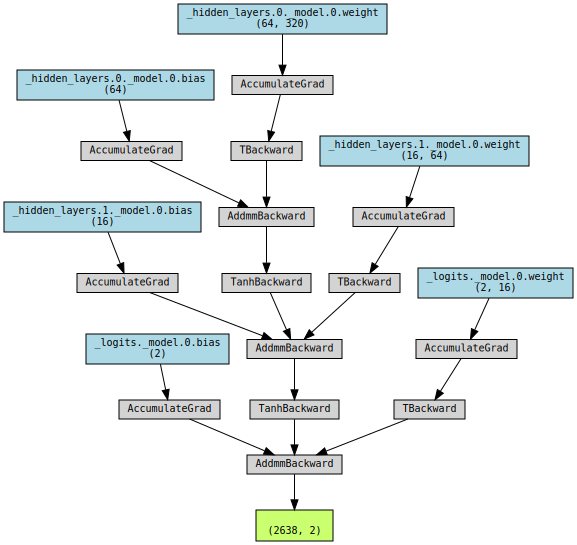

In [ ]:
from utils.utils import visualize_network
visualize_network(agent)

In [ ]:
agent.get_policy().model

FullyConnectedNetwork(
  (_logits): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=320, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=320, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [ ]:
agent.get_config()

{'num_workers': 4,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'complete_episodes',
 'gamma': 0.99,
 'lr': 5e-05,
 'train_batch_size': 4000,
 'model': {'_use_default_native_models': False,
  'fcnet_hiddens': [64, 16],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'attention_use_n_prev_actions': 0,
  